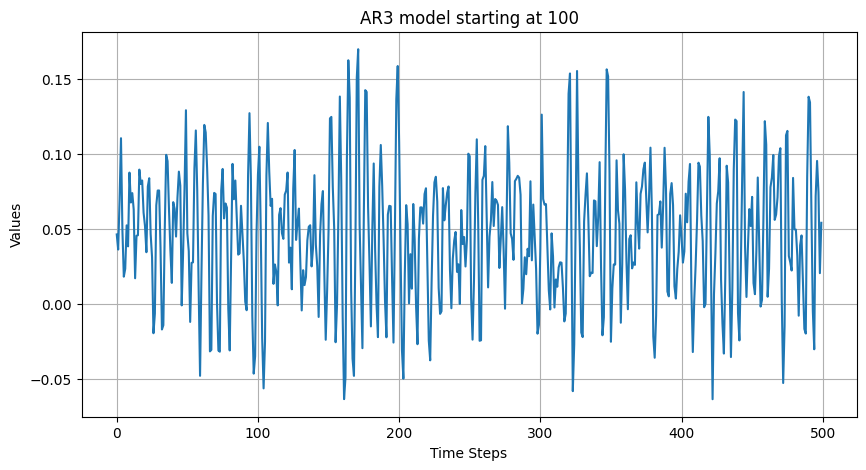

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

# Constants for the AR model
a1 = 0.6
a2 = -0.5
a3 = -0.2
n_samples = 600

# Initialize the array for storing X_t values
X = np.zeros(n_samples)

# Seed for reproducibility
np.random.seed(0)

# Generate ε_t from a uniform distribution U(0, 0.1)
epsilon = np.random.uniform(0, 0.1, n_samples)

# Initial values for X_1, X_2, X_3 are assumed to be zero
X[0] = epsilon[0]
X[1] = a1 * X[0] + epsilon[1]
X[2] = a1 * X[1] + a2 * X[0] + epsilon[2]

# Generate the series according to the AR model
for t in range(3, n_samples):
    X[t] = a1 * X[t - 1] + a2 * X[t - 2] + a3 * X[t - 3] + epsilon[t]

# Discard the first 100 samples
X_trimmed = X[100:]

# Plot the series
plt.figure(figsize=(10, 5))
plt.plot(X_trimmed)
plt.title('AR3 model starting at 100')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [48]:
# Prepare data for RNN training
def create_dataset(data, look_back=3):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back)]  # Fix: remove the unnecessary indexing by second dimension
        dataX.append(a)
        dataY.append(data[i + look_back])
    return np.array(dataX), np.array(dataY)


look_back = 10  # Using three previous timesteps to predict the next
X_data, y_data = create_dataset(X_trimmed, look_back)

# Reshape input to be [samples, time steps, features]
X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [49]:

# Define the RNN model
model = Sequential([
    SimpleRNN(50, input_shape=(look_back, 1), return_sequences=True),
    SimpleRNN(50),
    Dense(1)
])

# Compile the model with MAPE loss
model.compile(optimizer=Adam(learning_rate=0.01), loss="mean_squared_error")



# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1594 - val_loss: 0.0025
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6974e-04 - val_loss: 9.3578e-04
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3561e-04 - val_loss: 0.0011
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7235e-04 - val_loss: 0.0011
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


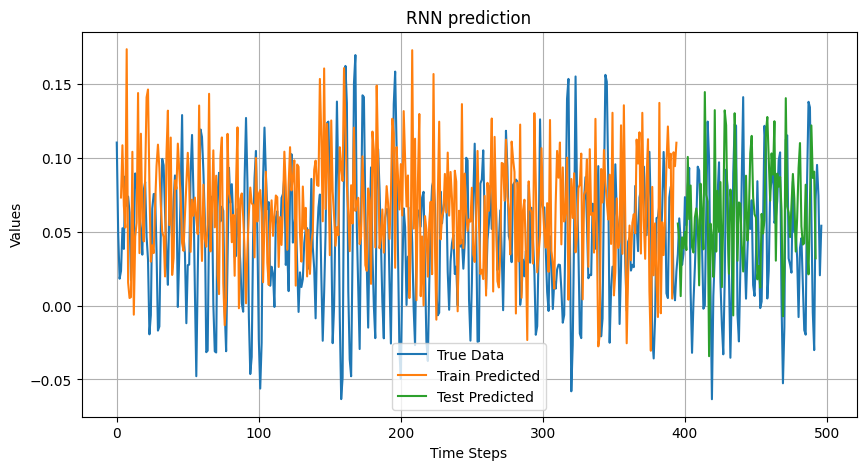

In [50]:

# Predict the values using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


# Plot the training and testing data with the prediction
plt.figure(figsize=(10, 5))
plt.plot(X_trimmed[3:], label='True Data')
plt.plot(np.arange(3, len(train_predict) + 3), train_predict, label='Train Predicted')
plt.plot(np.arange(len(train_predict) + 3, len(train_predict) + 3 + len(test_predict)), test_predict,
         label='Test Predicted')
plt.title('RNN prediction')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
# get metrics MSE MAE RMSE MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, rmse, mape

train_mse_RNN, train_mae_RNN, train_rmse_RNN, train_mape_RNN = get_metrics(y_train, train_predict)
test_mse_RNN, test_mae_RNN, test_rmse_RNN, test_mape_RNN = get_metrics(y_test, test_predict)

print(f'Training MSE: {train_mse_RNN:.4f}, MAE: {train_mae_RNN:.4f}, RMSE: {train_rmse_RNN:.4f}, MAPE: {train_mape_RNN:.4f}')
print(f'Testing MSE: {test_mse_RNN:.4f}, MAE: {test_mae_RNN:.4f}, RMSE: {test_rmse_RNN:.4f}, MAPE: {test_mape_RNN:.4f}')

Training MSE: 0.0013, MAE: 0.0302, RMSE: 0.0362, MAPE: 7.5838
Testing MSE: 0.0011, MAE: 0.0275, RMSE: 0.0331, MAPE: 1.3934


In [52]:
# now do the same for LSTM model
from tensorflow.keras.layers import LSTM

# Define the LSTM model
model = Sequential([
    LSTM(50, input_shape=(look_back, 1)),
    Dense(1)
])

# Compile the model with MAPE loss
model.compile(optimizer=Adam(learning_rate=0.01), loss="mean_squared_error")

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 8.5360e-04
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1852e-04 - val_loss: 9.4892e-04
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3153e-04 - val_loss: 9.3394e-04
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5661e-04 - val_loss: 8.5373e-04
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1479e-04 - val_loss: 9.0996e-04
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7152e-04 - val_loss: 8.8629e-04
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3046e-04 - val_loss: 8.7355e-04
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2213e-04 - val_loss: 8.8463e-04


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


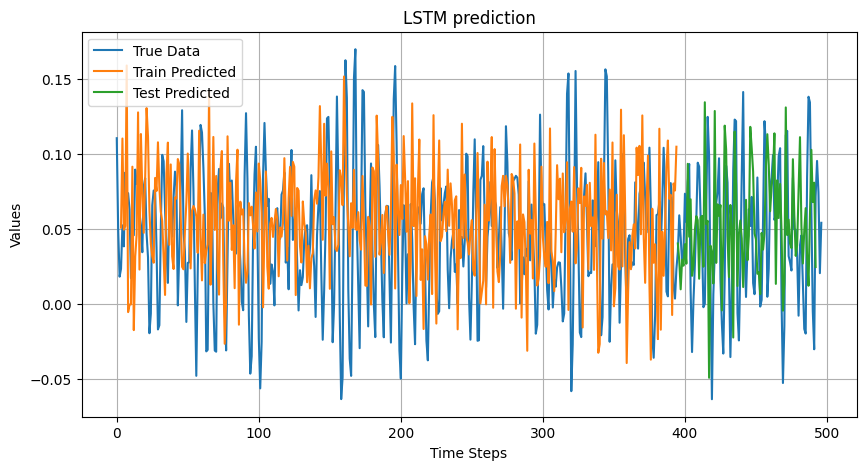

In [53]:

# Predict the values using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Plot the training and testing data with the prediction
plt.figure(figsize=(10, 5))
plt.plot(X_trimmed[3:], label='True Data')
plt.plot(np.arange(3, len(train_predict) + 3), train_predict, label='Train Predicted')
plt.plot(np.arange(len(train_predict) + 3, len(train_predict) + 3 + len(test_predict)), test_predict,
         label='Test Predicted')
plt.title('LSTM prediction')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# get metrics MSE MAE RMSE MAPE
train_mse, train_mae, train_rmse, train_mape = get_metrics(y_train, train_predict)
test_mse, test_mae, test_rmse, test_mape = get_metrics(y_test, test_predict)

print("RNN")
print(f'Training MSE: {train_mse_RNN:.4f}, MAE: {train_mae_RNN:.4f}, RMSE: {train_rmse_RNN:.4f}, MAPE: {train_mape_RNN:.4f}')
print(f'Testing MSE: {test_mse_RNN:.4f}, MAE: {test_mae_RNN:.4f}, RMSE: {test_rmse_RNN:.4f}, MAPE: {test_mape_RNN:.4f}')
print("LSTM")
print(f'Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, MAPE: {train_mape:.4f}')
print(f'Testing MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, MAPE: {test_mape:.4f}')

RNN
Training MSE: 0.0013, MAE: 0.0302, RMSE: 0.0362, MAPE: 7.5838
Testing MSE: 0.0011, MAE: 0.0275, RMSE: 0.0331, MAPE: 1.3934
LSTM
Training MSE: 0.0010, MAE: 0.0272, RMSE: 0.0317, MAPE: 6.5192
Testing MSE: 0.0009, MAE: 0.0250, RMSE: 0.0297, MAPE: 1.1259


In [55]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
lookbacks = [1, 2, 3, 5, 7, 10, 20, 30, 50]
test_MAPES_RNN = []
test_MSES_RNN = []
test_MAPES_LSTM = []
test_MSES_LSTM = []

for look_back in lookbacks:
    X_data, y_data = create_dataset(X_trimmed, look_back)
    X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1))
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

    # RNN
    model = Sequential([
        SimpleRNN(50, input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(50),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss="mean_squared_error")
    model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0)
    test_predict = model.predict(X_test)
    test_mape = mean_absolute_percentage_error(y_test, test_predict)
    test_mse = mean_squared_error(y_test, test_predict)
    test_MAPES_RNN.append(test_mape)
    test_MSES_RNN.append(test_mse)

    # LSTM
    model = Sequential([
        LSTM(50, input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss="mean_squared_error")
    model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0)
    test_predict = model.predict(X_test)
    test_mape = mean_absolute_percentage_error(y_test, test_predict)
    test_mse = mean_squared_error(y_test, test_predict)
    test_MAPES_LSTM.append(test_mape)
    test_MSES_LSTM.append(test_mse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


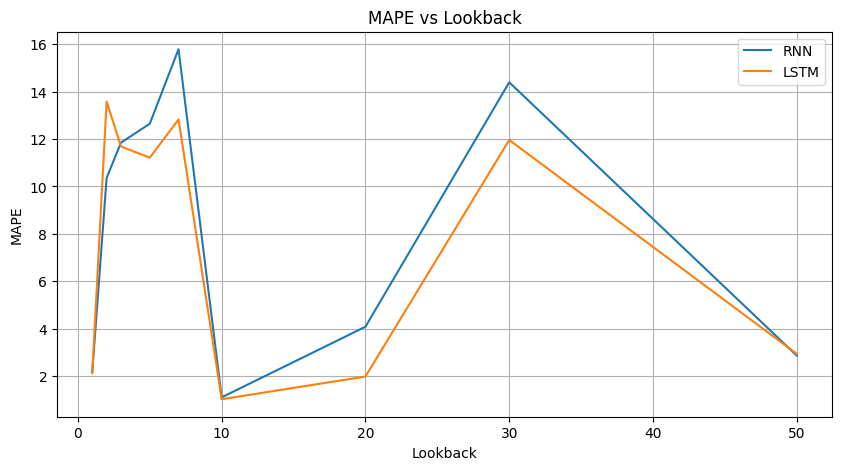

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(lookbacks, test_MAPES_RNN, label='RNN')
plt.plot(lookbacks, test_MAPES_LSTM, label='LSTM')
plt.title('MAPE vs Lookback')
plt.xlabel('Lookback')
plt.ylabel('MAPE')
plt.legend()
plt.grid(True)
plt.show()

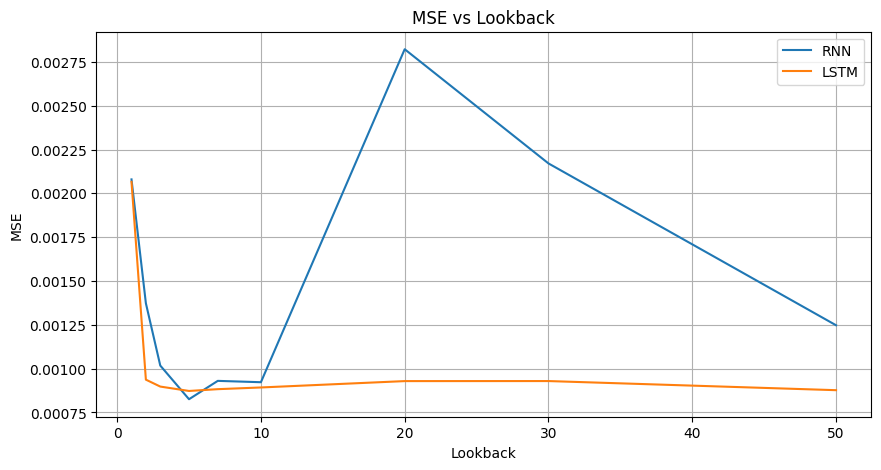

In [58]:
# Plot the MSE vs lookback
plt.figure(figsize=(10, 5))
plt.plot(lookbacks, test_MSES_RNN, label='RNN')
plt.plot(lookbacks, test_MSES_LSTM, label='LSTM')
plt.title('MSE vs Lookback')
plt.xlabel('Lookback')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

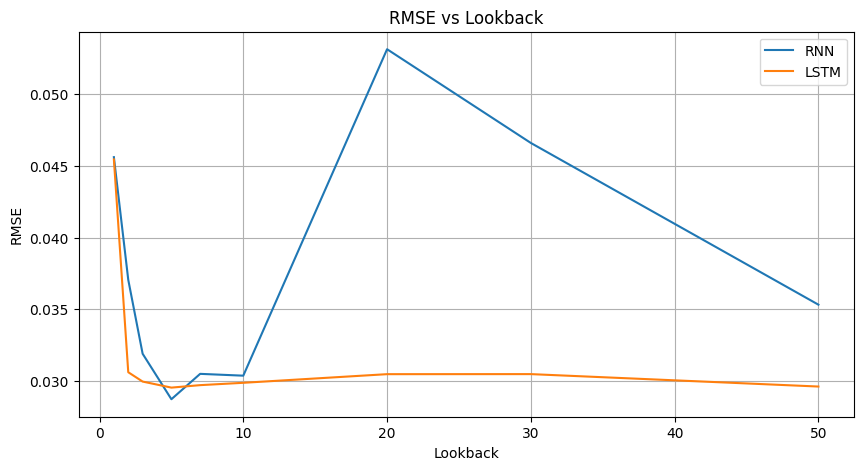

In [59]:
# get RMSES
test_RMSES_RNN = np.sqrt(test_MSES_RNN)
test_RMSES_LSTM = np.sqrt(test_MSES_LSTM)

# Plot the RMSE vs lookback
plt.figure(figsize=(10, 5))
plt.plot(lookbacks, test_RMSES_RNN, label='RNN')
plt.plot(lookbacks, test_RMSES_LSTM, label='LSTM')
plt.title('RMSE vs Lookback')
plt.xlabel('Lookback')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()